In [58]:
from array import array
import numpy as np
import struct
import matplotlib.pyplot as plt
from typing import Dict, List
import random
from multiprocessing import Pool

f1 = open("./archive/train-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f1.read(16))
imgs1 = np.array(array("B", f1.read()), dtype=np.uint32).reshape((-1, 28, 28))

f2 = open("archive/t10k-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f2.read(16))
imgs2 = np.array(array("B", f2.read()), dtype=np.uint32).reshape((-1, 28, 28))

imgs = np.concat((imgs1, imgs2), axis=0)
print(imgs.shape)

(70000, 28, 28)


(70000, 28, 28)


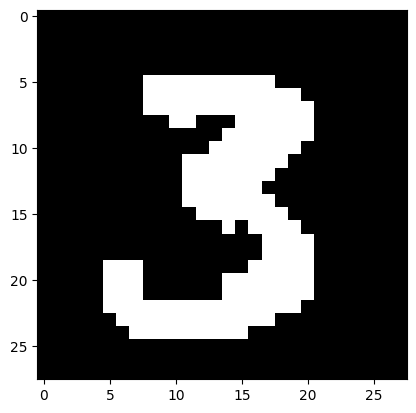

In [59]:
from array import array
import numpy as np
import struct
import matplotlib.pyplot as plt
from typing import Dict

f1 = open("archive/train-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f1.read(16))
imgs1 = np.array(array("B", f1.read()), dtype=np.bool).reshape((-1, 28, 28)).astype(np.float32)

f2 = open("archive/t10k-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f2.read(16))
imgs2 = np.array(array("B", f2.read()), dtype=np.bool).reshape((-1, 28, 28)).astype(np.float32)

imgs = np.concat((imgs1, imgs2), axis=0)
print(imgs.shape)

plt.imshow(random.choice(imgs), cmap="gray")
plt.show()

In [60]:
THRESHOLD = 1.
N_ATOMS = 100
COOLING_RATE = 0.001
DELTA_SIGMA = 0.01

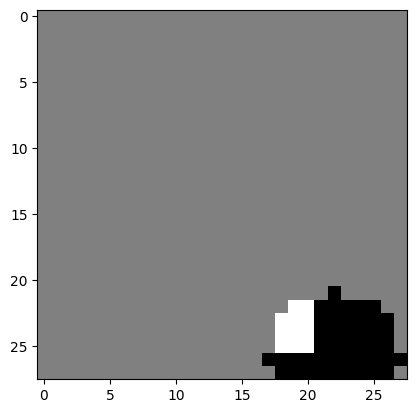

In [61]:
class AtomNode:
    def __init__(self, vector):
        self.vector = vector
        self.strength = random.normalvariate()
        self.active = 0
        self.input = 0
        self.weights = None

    def update(self, temp):
        prob = 1 / (1 + np.exp(-self.input / temp))
        self.active = random.choices([0, 1], [1-prob, prob])[0]

    def generate_weights(self):
        self.weights = self.vector * (self.strength / np.count_nonzero(self.vector))

    def calculate_input(self, representation_vector):
        self.generate_weights()
        self.input = np.dot(self.weights.flat, representation_vector.flat) - self.strength * THRESHOLD


xs = np.array([[i for i in range(28)] for _ in range(28)])
ys = np.array([[j for _ in range(28)] for j in range(28)])

def atomize(image):
    x, y = random.randint(0, 28), random.randint(0, 28)
    r = random.randint(3, 6)

    ins = ((xs - x) ** 2 + (ys - y) ** 2) ** 0.5 <= r
    image[image == 0] = -1
    atom_vector = np.multiply(image, ins)
    atom_vector[ins == 0] = 0

    return AtomNode(atom_vector)

img = random.choice(imgs)
plt.imshow(atomize(img).vector, cmap="gray", vmin=-1, vmax=1)
plt.show()

In [62]:
def hk(representation_vector, atom: AtomNode):
    return np.dot(representation_vector.flat, atom.vector.flat) / np.count_nonzero(atom.vector) - THRESHOLD

In [63]:
class FeatureSet:
    def __init__(self, fixed_vector):
        self.vector = np.zeros((28, 28))
        self.input = np.zeros((28, 28))
        self.fixed = fixed_vector

    def update(self, temp):
        probs = 1 / (1 + np.exp(self.input) / temp)
        self.vector = (np.random.uniform(0., 1., size=(28, 28)) < probs).astype(float)
        self.vector[self.fixed != 0] = self.fixed[self.fixed != 0]

    def calculate_input(self, atoms: List[AtomNode]):
        self.input = 2 * sum([atom.vector * atom.active for atom in atoms])

In [64]:
class AtomSet:
    def __init__(self):
        atoms = random.choices(list(imgs), k=N_ATOMS)
        self.atoms = Pool(processes=4).map(atomize, atoms)

    def learn_example(self, example):
        for atom in self.atoms:
            if hk(example, atom) > 0:
                atom.strength += DELTA_SIGMA

    def train(self, n=1000):
        print("training")

        for i in range(n):
            self.learn_example(random.choice(imgs))
            
    def dampen(self, n=1000):
        print("dampening")
        f = FeatureSet(np.zeros((28, 28)))

        for i in range(n):
            f.calculate_input(self.atoms)
            f.update(1)
            
            for atom in self.atoms:
                atom.calculate_input(f.vector)
                atom.update(1)
                if hk(f.vector, atom) > 0:
                    atom.strength -= DELTA_SIGMA

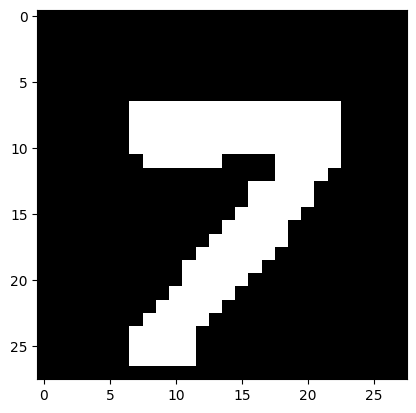

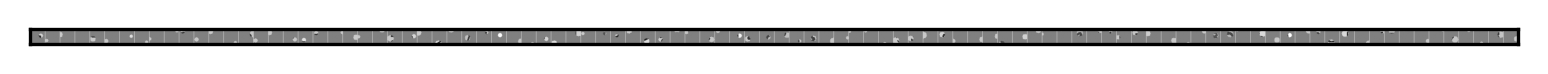

In [65]:
atoms = AtomSet()

img = random.choice(imgs)
atom = random.choice(atoms.atoms)
h = hk(img, atom)

grid = np.zeros((28, 28 * N_ATOMS))
img = random.choice(imgs)

for i, atom in enumerate(atoms.atoms):
    h = hk(img, atom)
    grid[:, i * 28: (i + 1) * 28] = atom.vector * h
    grid[:, i * 28] = 1

plt.imshow(img, cmap="gray")
plt.show()

_, ax = plt.subplots(1, 1, dpi=300)
ax.imshow(grid, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [66]:
def Hk(representation_vector, atoms: List[AtomNode]):
    return sum([atom.strength * atom.active * hk(representation_vector, atom) for atom in atoms])

In [67]:
for i in range(50):
    print(i)
    atoms.train(n=1000)
    # atoms.dampen(n=1000)

0
training
1
training
2
training
3
training
4
training
5
training
6
training
7
training
8
training
9
training
10
training
11
training
12
training
13
training
14
training
15
training
16
training
17
training
18
training
19
training
20
training
21
training
22
training
23
training
24
training
25
training
26
training
27
training
28
training
29
training
30
training
31
training
32
training
33
training
34
training
35
training
36
training
37
training
38
training
39
training
40
training
41
training
42
training
43
training
44
training
45
training
46
training
47
training
48
training
49
training


In [ ]:
import dearpygui.dearpygui as dpg

a = AtomSet()
image = random.choice(imgs)
f = FeatureSet(atomize(image).vector)
t = 10

CANVAS_SIZE = 560

dpg.create_context()

with dpg.window():
    dpg.set_primary_window(dpg.last_item(), True)

    with dpg.drawlist(width=CANVAS_SIZE, height=CANVAS_SIZE):
        for i in range(28):
            for j in range(28):
                dpg.draw_circle((i * 20, j * 20), 10, tag=f"node_{i}_{j}")

dpg.create_viewport(width=560, height=560)
dpg.setup_dearpygui()
dpg.show_viewport()

while dpg.is_dearpygui_running():
    f.calculate_input(a.atoms)
    f.update(t)
    for atom in a.atoms:
        atom.calculate_input(f.vector)
        atom.update(t)

    if t - COOLING_RATE > 0.:
        t -= COOLING_RATE

    print(t)

    for i in range(28):
        for j in range(28):
            color = (0, 0, 255) if f.fixed[i, j] else [max(0, f.vector[i, j]) * 255] * 3
            dpg.configure_item(f"node_{i}_{j}", fill=[max(0, f.vector[i, j]) * 255] * 3, color=color)
    dpg.render_dearpygui_frame()

dpg.destroy_context()

9.999
9.998000000000001
9.997000000000002
9.996000000000002
9.995000000000003
9.994000000000003
9.993000000000004
9.992000000000004
9.991000000000005
9.990000000000006
9.989000000000006
9.988000000000007
9.987000000000007
9.986000000000008
9.985000000000008
9.984000000000009
9.98300000000001
9.98200000000001
9.98100000000001
9.980000000000011
9.979000000000012
9.978000000000012
9.977000000000013
9.976000000000013
9.975000000000014
9.974000000000014
9.973000000000015
9.972000000000016
9.971000000000016
9.970000000000017
9.969000000000017
9.968000000000018
9.967000000000018
9.966000000000019
9.96500000000002
9.96400000000002
9.96300000000002
9.962000000000021
9.961000000000022
9.960000000000022
9.959000000000023
9.958000000000023
9.957000000000024
9.956000000000024
9.955000000000025
9.954000000000025
9.953000000000026
9.952000000000027
9.951000000000027
9.950000000000028
9.949000000000028
9.948000000000029
9.94700000000003
9.94600000000003
9.94500000000003
9.944000000000031
9.94300000000

/tmp/ipykernel_62254/2321580236.py:10: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(-self.input / temp))


-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.0009999999998974085
-0.00099999